In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import copy
import pickle
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.layers import BatchNormalization, Layer, TimeDistributed, Dropout
from keras.layers import Dense, Input, Masking, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


## Data Loading and Pre-Processing

Let's start by trying to load in our toy jets, and then separate into features (to train on) and labels (to predict).

For features, first try d0, z0, phi, theta, qOverP, (refPx, refPy, refPz)?. Essentially the track parameters.

For labels, Xs, Ys, Zs, Xt, Yt, Zt. That is the secondary and tertiary vertices. Omit the primary as this has been fixed to (0,0,0). This will require some smart selection for c and light jets, where not all vertices are present. If a vertex is not present, could try predicting (0,0,0) or (-1,-1,-1) or previous vertex (prim or sec).

In [2]:
bjets_DF = pd.read_pickle("./bjets_NaN_and_oneOverP_errs.pkl")
#cjets_DF = pd.read_pickle("./cjets.pkl")
#ljets_DF = pd.read_pickle("./ljets.pkl")

Extract the track parameters as our features

In [46]:
%%time
trks=np.zeros((len(bjets_DF), 30, 5))

for i in range(len(bjets_DF)):
    trks[i] = np.array([bjets_DF['tracks'][i]])[:,:,0:5]
    


Wall time: 15.2 s


In [47]:
X = trks # following convention name the features as the vector 'X'

In [79]:
#X = np.nan_to_num(X)

### Data Handling: Change 1/p to p

Let's try changing the 1/p feature to p, see what happens

 No Change to end accuracy nor speed-up so won't do this

In [80]:
#1/X[:,:,4]  # these are individual tracks remember so p<10,000 is allowed

array([[ 4850.46696803,  3060.74292196,  4054.83541082, ...,
                   nan,            nan,            nan],
       [ 2050.96833157,  5200.69668043,  1918.47163884, ...,
                   nan,            nan,            nan],
       [ 3774.24046227, 14472.05631949,  2894.37128725, ...,
                   nan,            nan,            nan],
       ...,
       [ 2883.77907606,  5114.71929641,  2072.69149129, ...,
                   nan,            nan,            nan],
       [ 2566.318433  ,   620.46562403,   563.21545658, ...,
                   nan,            nan,            nan],
       [ 4284.22553045,  7638.42365794,  1493.57056224, ...,
                   nan,            nan,            nan]])

In [81]:
#X[:,:,4] = 1/X[:,:,4]

In [82]:
#X = np.nan_to_num(X)

### Track Ordering

Use numpy sort function should work, order in descending value say of impact parameter or something (shouldnt be any negatives)

In [45]:
np.min(X[:,:,0])

0.0

In [49]:
%%time

# This code should do the trick, ordering here by d0 in descinding order,
# checked that there are no d0 negative vals, so i don't take absolute values

for jet in range(len(bjets_DF)):
    mat=np.nan_to_num(X[jet]) # Converts nan to 0.0 !!! May need to run this step later if want to minmax scale
    mat_sort = mat[mat[:,0].argsort()[::-1]]
    X[jet]=mat_sort

Wall time: 4.37 s


In [50]:
X

array([[[ 7.48773333e-04, -9.65963118e-05, -2.11493938e+00,
          2.93390487e+00,  1.62024732e-04],
        [ 4.67363941e-04,  2.17068009e-05, -1.77145540e+00,
          3.09125710e+00,  7.33671864e-05],
        [ 4.35472118e-04, -1.23074278e-05, -1.04056037e+00,
          2.98124820e+00,  1.58138612e-04],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00]],

       [[ 1.95433368e-03, -2.58651399e-03,  6.42807661e-01,
          1.04267568e+00,  2.32396558e-04],
        [ 1.93720514e-03,  1.43839722e-03,  5.82598525e-01,
          1.40702647e+00,  1.48369940e-04],
        [ 7.81975509e-04,  1.57580711e-04,  8.11333647e-01,
          1.30535613e+00,  4.47963290e-05],
        ...,
        [ 0.00000000e+00,  0.0000000

## Data Normalization

I think we want to ensure all paramters are approx unity in order not to bias the RNN towards a particular feature. phi and theta are already approx unity (order pi), but qOverP is very small order 1e-4 and IP are also small (but scale multiple orders of magnitude) 1e-6 to 1e-2 (unfortunately)

So maybe want to use a min max scaler or some thing.

(array([4.13328e+05, 3.94200e+04, 2.76730e+04, ..., 0.00000e+00,
        0.00000e+00, 1.00000e+00]),
 array([1.44259736e-09, 2.48700174e-05, 4.97385922e-05, ...,
        2.58135821e-02, 2.58384507e-02, 2.58633192e-02]),
 <a list of 1040 Patch objects>)

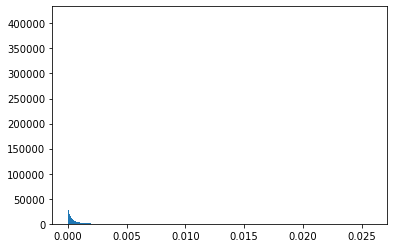

In [66]:
d0s = np.reshape(X[:,:,0],(3000000))
d0s = d0s[~(d0s == np.NaN)]
d0s
plt.hist(d0s,bins='scott') # I believe this is the array containing all the d0s

In [90]:
print(np.mean(X[:,:,0]*1e4))
print(np.mean(X[:,:,1]*1e6))
print(np.mean(X[:,:,4]*1e4))
print()
print(np.std(X[:,:,0]*1e4)) # these are troublesome yes
print(np.std(X[:,:,1]*1e6))
print(np.std(X[:,:,4]*1e4))
# so we will apply the above multiples, this will bring the averages to about unity (unfortunately some outliers will
# be very large, so probs better to use a min max scaler or something but then exclude 0?)

0.9568257995346341
0.31995557915629463
0.18227903038956314

4.016282118952634
347.65219898040107
0.5286935888204137


Here we scale all the features to bring them to average unity, this is very simplistic so we need a better way in future

It means it works faster.

In [91]:
firsttime=True

In [92]:
if firsttime==True:
    X[:,:,0]=X[:,:,0]*1e4
    X[:,:,1]=X[:,:,1]*1e6
    X[:,:,4]=X[:,:,4]/1e4
    firsttime = False

Here we instead use a min-max scaler to try and solve the problem of scale i.e. certain IPs are 10^4 times larger than others. The min-max scaler means all features will be scaled equivalently.

Here we go, minmax scaling

In [13]:
Xscaled = copy.copy(X)

In [14]:
for track_variable in range(5):
    var_to_scale = Xscaled[:,:,track_variable]
    if (track_variable == 2 or track_variable == 3):
        scaler=MinMaxScaler([-1,1])
    else:
        scaler=MinMaxScaler([0,1])
    scaler.fit(var_to_scale)
    Xscaled[:,:,track_variable] = scaler.transform(var_to_scale)

C:\Users\Greg\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:355: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\Greg\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:356: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\Greg\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:355: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\Greg\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:356: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\Greg\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:355: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\Greg\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:356: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\Greg\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:355: Runti

3000000


C:\Users\Greg\Anaconda3\lib\site-packages\numpy\lib\histograms.py:391: RuntimeWarning: invalid value encountered in greater_equal
  keep = (a >= first_edge)
C:\Users\Greg\Anaconda3\lib\site-packages\numpy\lib\histograms.py:392: RuntimeWarning: invalid value encountered in less_equal
  keep &= (a <= last_edge)
C:\Users\Greg\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Greg\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


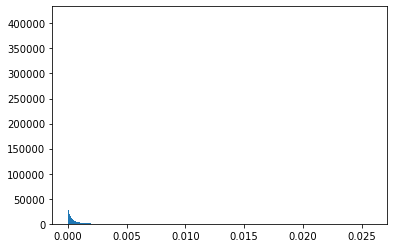

In [15]:
trackvar = X[:,:,0]
trackvar = trackvar[~(trackvar == np.NaN)]
print(len(trackvar))

plt.hist(trackvar,bins='scott')
plt.show()

3000000


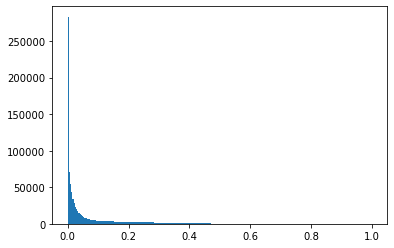

In [16]:
trackvar = Xscaled[:,:,0]
trackvar = trackvar[~(trackvar == np.NaN)]
print(len(trackvar))


plt.hist(trackvar,bins='scott')
plt.show()

In [17]:
Xscaled = np.nan_to_num(Xscaled)

Now we scale the outputs, actually more simple, we change units from metres to millimetres

And the secondary and tertiary vertices as our labels

In [93]:
y = bjets_DF[['secVtx_x','secVtx_y','secVtx_z','terVtx_x','terVtx_y','terVtx_z']].values 
y = y*1000 # change units of vertices from m to mm, keep vals close to unity
# again convention call labels 'y'

Split first 80000 jets as train and next 20000 as test. Below some plots to show these jets are equivalently distributed

In [19]:
X=np.nan_to_num(X)

In [95]:
X_train=X[:90000]
X_test=X[90000:]
y_train=y[:90000]
y_test=y[90000:]

In [96]:
b_s1=np.linalg.norm(bjets_DF[['secVtx_x','secVtx_y','secVtx_z']],axis=1)[:90000]
b_s2=np.linalg.norm(bjets_DF[['secVtx_x','secVtx_y','secVtx_z']],axis=1)[90000:]
b_t1=np.linalg.norm(bjets_DF[['terVtx_x','terVtx_y','terVtx_z']],axis=1)[:90000]
b_t2=np.linalg.norm(bjets_DF[['terVtx_x','terVtx_y','terVtx_z']],axis=1)[90000:]
plt.show()

0.003680845648113255
0.007007205248563903


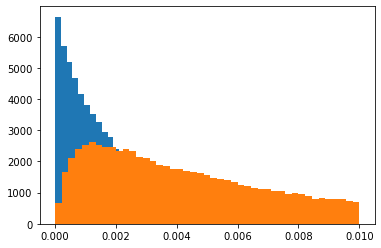

In [97]:
plt.hist(b_s1,bins='scott',range=[0,0.01])
#plt.hist(c_SecVtx,bins='scott',range=[0,0.01])
plt.hist(b_t1,bins='scott',range=[0,0.01])

print(np.mean(b_s1))
print(np.mean(b_t1))


0.003685262818106623
0.007117036917486118


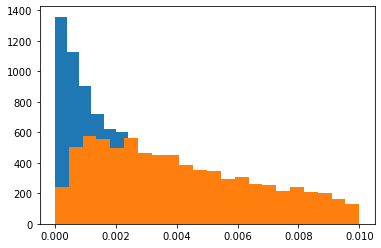

In [98]:
plt.hist(b_s2,bins='scott',range=[0,0.01])
#plt.hist(c_SecVtx,bins='scott',range=[0,0.01])
plt.hist(b_t2,bins='scott',range=[0,0.01])

print(np.mean(b_s2))
print(np.mean(b_t2))


So finally we have our features, X, and labels, y. Split into training and testing samples.

## Data Plots and Sanity Checks

Here I should have some plots on the track variables to ensure everything is logical and working fine, especially when I make changes to the data. Can potentially use seaborn...

## Constructing and Training an RNN

Here we create an RNN based on LSTM cells using keras and tensorflow. The RNN will for each jet candidate take the tracks as inputs and attempt to predict the secondary and tertiary vertex positions. Let's see how well it does.

I anticipate having to set a tolerance on the predicted values, it will never get them perfectly but we need to tell it how close it has to get for it to be considered successful.

Let's begin by creating the RNN architecture

In [99]:
# Select number of hidden and dense layers. Initially use same as RNNIP but these can be tuned going forward.

nHidden = 100
nDense = 20

In [100]:
nJets, nTrks, nFeatures = X_train.shape
nOutputs = y.shape[1] # ie sec and ter vtx xyz, so 6

In [101]:
trk_inputs = Input(shape=(nTrks,nFeatures),name="Trk_inputs")
masked_input = Masking()(trk_inputs)

# Feed this merged layer to an RNN
lstm = LSTM(nHidden, return_sequences=False, name='LSTM')(masked_input)
dpt = Dropout(rate=0.2)(lstm) # this is a very high dropout rate, reduce it

my_inputs = trk_inputs

# Fully connected layer: This will convert the output of the RNN to our vtx postion predicitons
FC = Dense(nDense, activation='relu', name="Dense")(dpt) # is relu fine here? i think so...

# Ouptut layer. Sec and Ter Vtx. No activation as this is a regression problem
output = Dense(nOutputs, name="Vertex_Predictions")(FC)

myRNN = Model(inputs=my_inputs, outputs=output)


In [102]:
myRNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Trk_inputs (InputLayer)      (None, 30, 5)             0         
_________________________________________________________________
masking_3 (Masking)          (None, 30, 5)             0         
_________________________________________________________________
LSTM (LSTM)                  (None, 100)               42400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
Dense (Dense)                (None, 20)                2020      
_________________________________________________________________
Vertex_Predictions (Dense)   (None, 6)                 126       
Total params: 44,546
Trainable params: 44,546
Non-trainable params: 0
_________________________________________________________________


In [103]:
myRNN.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae']) # do i want to add a metric like mse to evaluate during training


 checkpoints, training, evaluation of performance
 different ways of evaluating performance obviously
 either akin to Nicole's method for RNNIP
 or the slighlty different method in https://github.com/agu3rra/NeuralNetwork-RegressionExample/blob/master/Tutorial.ipynb

In [104]:
myRNN_mChkPt = ModelCheckpoint('myRNN_weights.h5',monitor='val_loss', verbose=True,
                               save_best_only=True,
                               save_weights_only=True)

In [105]:
earlyStop = EarlyStopping(monitor='val_loss', verbose=True, patience=10)


In [106]:
nEpochs = 100

myRNN_hist = myRNN.fit(X_train, y_train, epochs=nEpochs, batch_size=256,validation_split=0.20,
                 callbacks=[earlyStop, myRNN_mChkPt],) # callbacks=[earlyStop, myRNN_mChkPt])

Train on 72000 samples, validate on 18000 samples
Epoch 1/100
72000/72000 [==============================] - 23s 325us/step - loss: 1.9783 - mean_absolute_error: 1.9783 - val_loss: 1.4952 - val_mean_absolute_error: 1.4952
Epoch 2/100
72000/72000 [==============================] - 23s 318us/step - loss: 1.3266 - mean_absolute_error: 1.3266 - val_loss: 1.1248 - val_mean_absolute_error: 1.1248
Epoch 3/100
72000/72000 [==============================] - 24s 328us/step - loss: 1.1415 - mean_absolute_error: 1.1415 - val_loss: 0.9933 - val_mean_absolute_error: 0.9933
Epoch 4/100
72000/72000 [==============================] - 25s 345us/step - loss: 1.0760 - mean_absolute_error: 1.0760 - val_loss: 0.9430 - val_mean_absolute_error: 0.9430
Epoch 5/100
72000/72000 [==============================] - 25s 341us/step - loss: 1.0334 - mean_absolute_error: 1.0334 - val_loss: 0.9523 - val_mean_absolute_error: 0.9523
Epoch 6/100
72000/72000 [==============================] - 24s 337us/step - loss: 1.0136 -

72000/72000 [==============================] - 27s 370us/step - loss: 0.8223 - mean_absolute_error: 0.8223 - val_loss: 0.7432 - val_mean_absolute_error: 0.7432
Epoch 50/100
72000/72000 [==============================] - 24s 328us/step - loss: 0.8250 - mean_absolute_error: 0.8250 - val_loss: 0.7484 - val_mean_absolute_error: 0.7484
Epoch 51/100
72000/72000 [==============================] - 27s 375us/step - loss: 0.8214 - mean_absolute_error: 0.8214 - val_loss: 0.7771 - val_mean_absolute_error: 0.7771
Epoch 52/100
72000/72000 [==============================] - 24s 330us/step - loss: 0.8221 - mean_absolute_error: 0.8221 - val_loss: 0.7512 - val_mean_absolute_error: 0.7512
Epoch 53/100
72000/72000 [==============================] - 25s 353us/step - loss: 0.8176 - mean_absolute_error: 0.8176 - val_loss: 0.7324 - val_mean_absolute_error: 0.7324
Epoch 54/100
72000/72000 [==============================] - 24s 337us/step - loss: 0.8118 - mean_absolute_error: 0.8118 - val_loss: 0.7331 - val_mea

Epoch 74/100
72000/72000 [==============================] - 24s 335us/step - loss: 0.7627 - mean_absolute_error: 0.7627 - val_loss: 0.7037 - val_mean_absolute_error: 0.7037
Epoch 75/100
72000/72000 [==============================] - 26s 363us/step - loss: 0.7634 - mean_absolute_error: 0.7634 - val_loss: 0.6742 - val_mean_absolute_error: 0.6742
Epoch 76/100
72000/72000 [==============================] - 25s 340us/step - loss: 0.7578 - mean_absolute_error: 0.7578 - val_loss: 0.7367 - val_mean_absolute_error: 0.7367
Epoch 77/100
72000/72000 [==============================] - 26s 359us/step - loss: 0.7590 - mean_absolute_error: 0.7590 - val_loss: 0.7180 - val_mean_absolute_error: 0.7180
Epoch 78/100
72000/72000 [==============================] - 25s 342us/step - loss: 0.7543 - mean_absolute_error: 0.7543 - val_loss: 0.6704 - val_mean_absolute_error: 0.6704
Epoch 79/100
72000/72000 [==============================] - 26s 366us/step - loss: 0.7473 - mean_absolute_error: 0.7473 - val_loss: 0.6

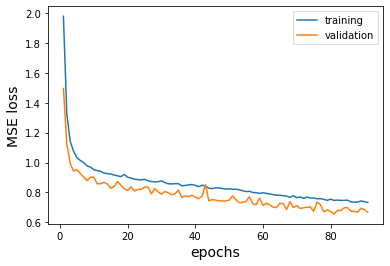

In [107]:
epochs = np.arange(1,len(myRNN_hist.history['loss'])+1)

plt.plot(epochs,myRNN_hist.history['loss'],label='training')
plt.plot(epochs,myRNN_hist.history['val_loss'],label='validation')
plt.xlabel('epochs',fontsize=14)
plt.ylabel('MSE loss',fontsize=14)
plt.legend()

In [49]:
results=myRNN.predict(X_test)

In [50]:
y_test

array([[-1.06539709e+00, -7.61532432e-01, -6.75432167e-01,
        -2.36472757e+00, -1.78343179e+00, -1.45118979e+00],
       [-2.50030854e-01,  6.98754926e-02, -8.97436086e-01,
        -3.03779238e-01,  5.93151184e-02, -1.03808858e+00],
       [-1.41926028e-03,  1.24233139e-02,  1.32501143e-02,
        -2.73928483e-01,  3.18875444e+00,  3.31695037e+00],
       ...,
       [ 2.59502785e-01,  1.18875115e+00, -1.19260277e+00,
         2.08426245e+00,  1.37403028e+01, -1.40827716e+01],
       [-8.54168917e-01, -2.13091426e+00,  1.97510391e+00,
        -1.34604489e+00, -3.59519445e+00,  3.74493634e+00],
       [ 2.61064368e+00,  4.71863327e-01,  5.97985815e-01,
         2.70212451e+00,  4.84300743e-01,  6.13586173e-01]])

In [52]:
np.mean((results-y_test)/y_test) # average error of 60%, so for vtx at 1mm, we get within 0.6mm

0.5925093147291125

In [27]:
bjets_DF.iloc[-1]

jet_energy                                               43075.4
jet_flavour                                                    5
secVtx_x                                              0.00417528
secVtx_y                                             -0.00100887
secVtx_z                                              0.00289704
terVtx_x                                              0.00559305
terVtx_y                                             -0.00135187
terVtx_z                                              0.00407726
tracks         [[2.010621651929816e-06, -4.989406079403125e-0...
Name: 99999, dtype: object

In [ ]:
# look at worst perfoming cases and examine the tracks
# look at actual uncertainty on overlap for the vertex
# re-run with minimised errors on tracks see if performance is better

In [152]:
myRNN.predict(np.array([X_test[2]]))

array([[-0.05486715, -0.45196092, -2.455217  , -0.1861686 , -0.99255735,
        -5.3714914 ]], dtype=float32)

couple of things, first the RNN looks like it predicts the same value for all cases. This might be because it uses the null tracks at the end of every single jet and just predicts off of those.
Maybe should consider predicting values that are at least order unity, because mse is gonna be very small otherwise, so convert the vertices into different units (I dunno maybe millimeters or microns)